# Quantifying the effect of COVID-19 on the Stock Market

Data Bootcamp Final
By Philip Ding, Zhen Yu Yang, and Sophia Park

# Question 1: Do COVID-19 death rates affect the stock market/industry indices? 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering as agglom
from scipy.spatial.distance import cdist as dist
from sklearn.cluster import KMeans as kmeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as linreg
from sklearn.neighbors import KNeighborsRegressor as knn
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import calendar


importing some packages

In [320]:
national = pd.read_csv('national-history.csv', error_bad_lines=False)
national2 = national.sort_values(by='date')
national2 = national2.set_index('date')
national

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,recovered,states,totalTestResults,totalTestResultsIncrease
0,2020-12-06,273374.0,1138,31946.0,20145.0,2256,101487.0,585676.0,161986294,1172590,3322.0,7094.0,14534035,176771,5624444.0,56,204063869,1634532
1,2020-12-05,272236.0,2445,31831.0,19950.0,3316,101190.0,583420.0,160813704,1526995,3321.0,7005.0,14357264,211073,5576026.0,56,202429337,2169756
2,2020-12-04,269791.0,2563,31608.0,19858.0,4652,101276.0,580104.0,159286709,1260657,3305.0,6999.0,14146191,224831,5470389.0,56,200259581,1854869
3,2020-12-03,267228.0,2706,31276.0,19723.0,5331,100755.0,575452.0,158026052,1238465,3280.0,6867.0,13921360,210204,5404018.0,56,198404712,1828230
4,2020-12-02,264522.0,2733,31038.0,19680.0,5028,100322.0,570121.0,156787587,982032,3252.0,6855.0,13711156,195796,5322128.0,56,196576482,1459202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,2020-01-26,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
316,2020-01-25,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
317,2020-01-24,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
318,2020-01-23,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,1


A national dataset of covid deaths per day, along with other covid statistics from https://covidtracking.com/data/download

In [321]:
industry = pd.read_csv('5_Industry_Portfolios_Daily.csv', error_bad_lines=False)
industry = industry.rename(columns={"Unnamed: 0": "date"})
industry['date'] = pd.to_datetime(industry['date'], format='%Y%m%d')
national['date'] = pd.to_datetime(national['date'])
industry

,date,Cnsmr,Manuf,HiTec,Hlth,Other
0,1926-07-01,-0.08,0.22,-0.11,0.97,0.21
1,1926-07-02,0.46,0.69,0.31,0.13,0.11
2,1926-07-06,0.27,0.28,0.32,0.23,-0.19
3,1926-07-07,-0.01,0.11,0.12,0.33,0.15
4,1926-07-08,0.24,0.09,0.38,0.91,0.39
...,...,...,...,...,...,...
24849,2020-10-26,-1.30,-1.88,-2.11,-1.06,-2.37
24850,2020-10-27,0.38,-1.13,0.53,-0.59,-1.64
24851,2020-10-28,-3.12,-3.13,-3.91,-3.01,-3.12
24852,2020-10-29,0.59,1.23,1.81,-0.15,0.94


Industry data taken from http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
Also converting dates to datetime format

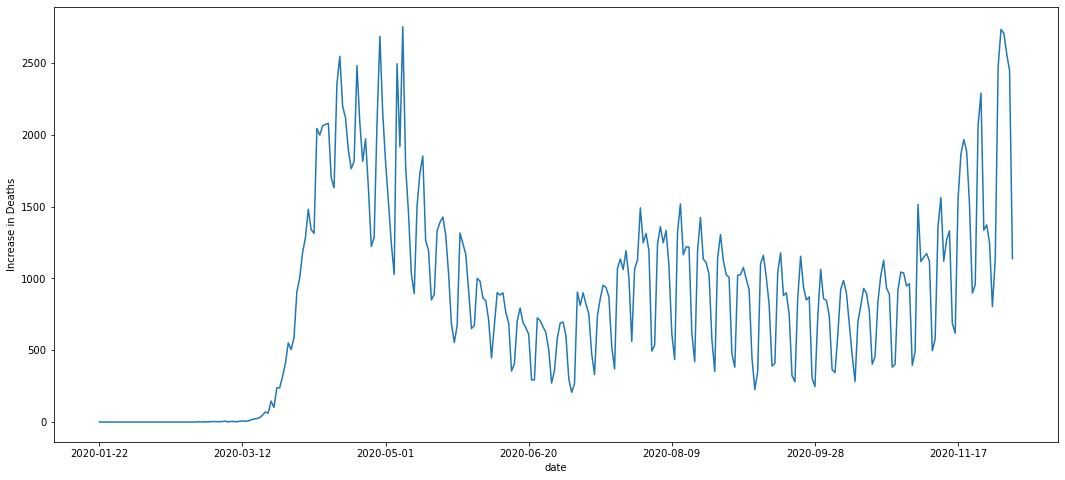

In [322]:
figure(figsize=(18,8))
plt.ylabel('Increase in Deaths')
national2['deathIncrease'].plot()

Quick plot of part of the data that we are analyzing. It is intersting to note the fluctuation in death increase - this could perhaps be explained by some phenomenon in sampling (for instance, maybe some states only periodically report their deaths). 

In [323]:
combined = industry
combined = combined.join(national.set_index('date'), on='date')
combined = combined[combined['deathIncrease'].notna()]
combined.set_index('date')
combined = combined.rename(columns={"Cnsmr": "consumer"})
combined["deathIncrease"] = pd.to_numeric(combined["deathIncrease"], downcast="float")
new_columns = combined.columns.values; 
new_columns[4] = 'health'; 
combined.columns  = new_columns
industry.set_index('date')
industry = industry.rename(columns={"Cnsmr": "consumer"})
new_columns = industry.columns.values; 
new_columns[4] = 'health'; 
industry.columns  = new_columns

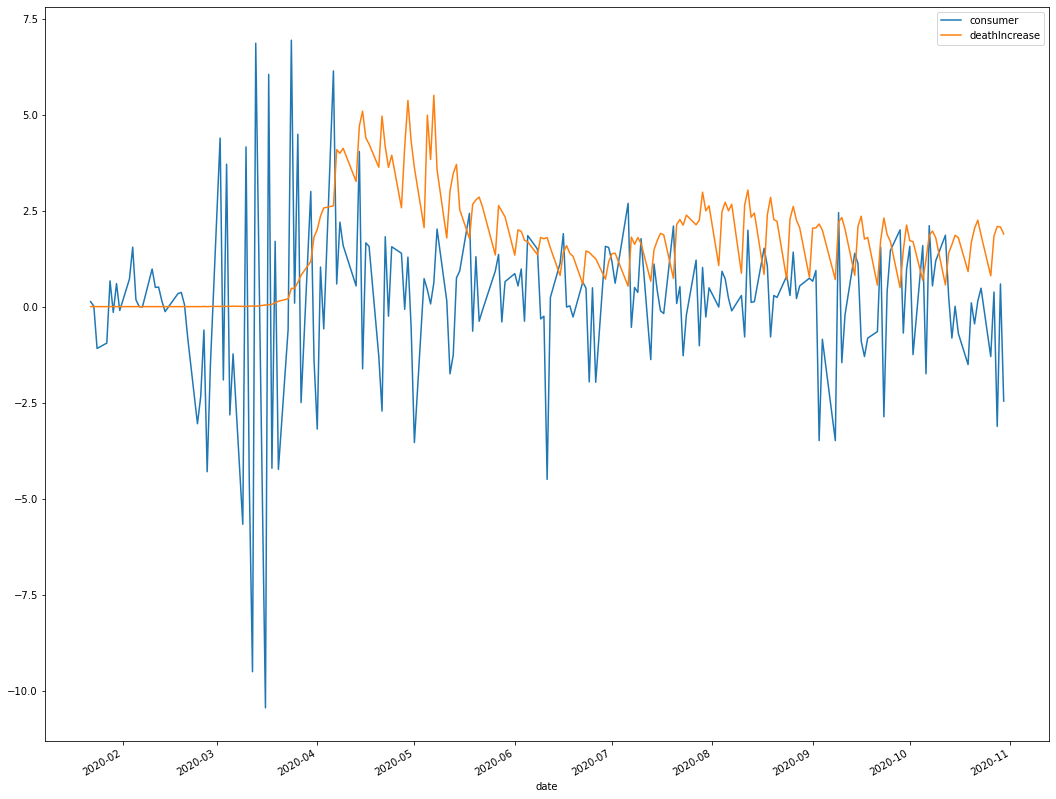

In [324]:
combined2 = combined.filter(['date','consumer','deathIncrease'])
combined2 = combined2.set_index('date')
combined2['deathIncrease'] = combined2['deathIncrease']/500
fig, ax = plt.subplots()
combined2.plot(ax=ax,kind='line',figsize = (18,15))


We can see from this graph immediately that the behavior and movement of stock indices looks at a cursory glance to operate differently from covid graphs - however, some of the bumps look visually to correlate

In [325]:
combined2 = combined.filter(['date','consumer','Manuf', 'HiTec', 'health', 'Other', 'deathIncrease'])
combined2.corr()

,consumer,Manuf,HiTec,health,Other,deathIncrease
consumer,1.000000,0.884822,0.958101,0.892906,0.885299,0.100900
Manuf,0.884822,1.000000,0.856809,0.871784,0.971035,0.117534
HiTec,0.958101,0.856809,1.000000,0.895201,0.868297,0.106578
health,0.892906,0.871784,0.895201,1.000000,0.850384,0.097926
Other,0.885299,0.971035,0.868297,0.850384,1.000000,0.109409
deathIncrease,0.100900,0.117534,0.106578,0.097926,0.109409,1.000000


The correlation of death increase and the five indices is very weak. This was expected, as the two inherently move in different ways - pandemics are somewhat consistently growing, while indices vary positive/negative with high variance day by day.

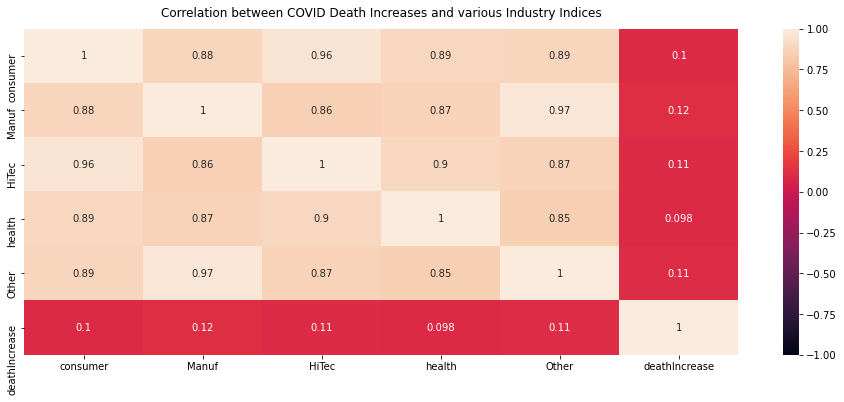

In [326]:
#corr = combined2.corr()
#fig = plt.figure()
#ax = fig.add_subplot(111)
#cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
#fig.colorbar(cax)
#ticks = np.arange(0,len(combined2.columns),1)
#ax.set_xticks(ticks)
#plt.xticks(rotation=90)
#ax.set_yticks(ticks)
#ax.set_xticklabels(combined2.columns)
#ax.set_yticklabels(combined2.columns)
#plt.show()
#my matplotlib heatmap broke, not sure why, didn't change anything - here's an SNS heatmap instead

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(combined2.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation between COVID Death Increases and various Industry Indices', fontdict={'fontsize':12}, pad=12);

A visualization of the aforementioned lack of correlation - the indices correspond heavily to each other, but hardly have a correlation with increase in deaths

In [327]:
combined['deltadeathincrease'] = combined['deathIncrease'] - combined['deathIncrease'].shift(-1)
combined['delta2deathincrease'] = combined['deltadeathincrease'] / combined['deltadeathincrease'].shift(-1)

Making two new variables - the difference and ratio of the change of the difference in death increase. These measurements should behave in ways more similar to the stock market indices, and it would not be surprising to see a negative correlation here with deltadeathincrease - given that a decrease in death rate seems like it would correlate with a rise in stocks and vice versa. Similarly with delta2deathincrease - perhaps trends of decreasing/increasing correspond with large shifts in stock indices.

In [328]:
combined_corr = combined.replace([np.inf, -np.inf], np.nan)
combined_corr = combined_corr[combined_corr['delta2deathincrease'].notna()]
column_1 = combined_corr['consumer']

column_2 = combined_corr['delta2deathincrease']

consumer_corr = column_1.corr(column_2)
Manuf_corr = combined_corr['Manuf'].corr(combined_corr['delta2deathincrease'])
HiTec_corr = combined_corr['HiTec'].corr(combined_corr['delta2deathincrease'])
health_corr = combined_corr['health'].corr(combined_corr['delta2deathincrease'])


In [329]:
combined2_corr = combined.replace([np.inf, -np.inf], np.nan)
combined2_corr = combined_corr[combined_corr['deltadeathincrease'].notna()]
consumer_corr2 = combined_corr['consumer'].corr(combined_corr['deltadeathincrease'])
Manuf_corr2 = combined_corr['Manuf'].corr(combined_corr['deltadeathincrease'])
HiTec_corr2 = combined_corr['HiTec'].corr(combined_corr['deltadeathincrease'])
health_corr2 = combined_corr['health'].corr(combined_corr['deltadeathincrease'])

In [330]:
print ("Consumer, Manufacturing, High Tech, and Health Correlations are:")
print (consumer_corr2, Manuf_corr2, HiTec_corr2, health_corr2)

Consumer, Manufacturing, High Tech, and Health Correlations are:
-0.07143423843153361 -0.00289854973086498 -0.039908750439652974 -0.0165566516199145


In [331]:
import numpy as np
import scipy.stats
manuf_r, manuf_p = scipy.stats.pearsonr(combined_corr['Manuf'], combined_corr['delta2deathincrease'])
consumer_r, consumer_p = scipy.stats.pearsonr(combined_corr['consumer'], combined_corr['delta2deathincrease'])
hitec_r, hitec_p = scipy.stats.pearsonr(combined_corr['HiTec'], combined_corr['delta2deathincrease'])
health_r, health_p = scipy.stats.pearsonr(combined_corr['health'], combined_corr['delta2deathincrease'])


In [332]:
print ("P value for manufacturing is: ", manuf_p)
print ("P value for consumer is: ", consumer_p)
print ("P value for high tech is: ", hitec_p)
print ("P value for health is: ", health_p)

P value for manufacturing is:  0.5482061896123934
P value for consumer is:  0.9802369802092401
P value for high tech is:  0.9004182231056465
P value for health is:  0.8066375742344323


In [333]:
combined3 = combined.filter(['date','consumer','Manuf', 'HiTec', 'health', 'Other','delta2deathincrease', 'deltadeathincrease'])
corr = combined3.corr()
corr

,consumer,Manuf,HiTec,health,Other,delta2deathincrease,deltadeathincrease
consumer,1.000000,0.884822,0.958101,0.892906,0.885299,-0.001903,-0.070049
Manuf,0.884822,1.000000,0.856809,0.871784,0.971035,-0.046096,0.001057
HiTec,0.958101,0.856809,1.000000,0.895201,0.868297,-0.009611,-0.037854
health,0.892906,0.871784,0.895201,1.000000,0.850384,0.018799,-0.013057
Other,0.885299,0.971035,0.868297,0.850384,1.000000,-0.041322,0.011611
delta2deathincrease,-0.001903,-0.046096,-0.009611,0.018799,-0.041322,1.000000,-0.135215
deltadeathincrease,-0.070049,0.001057,-0.037854,-0.013057,0.011611,-0.135215,1.000000


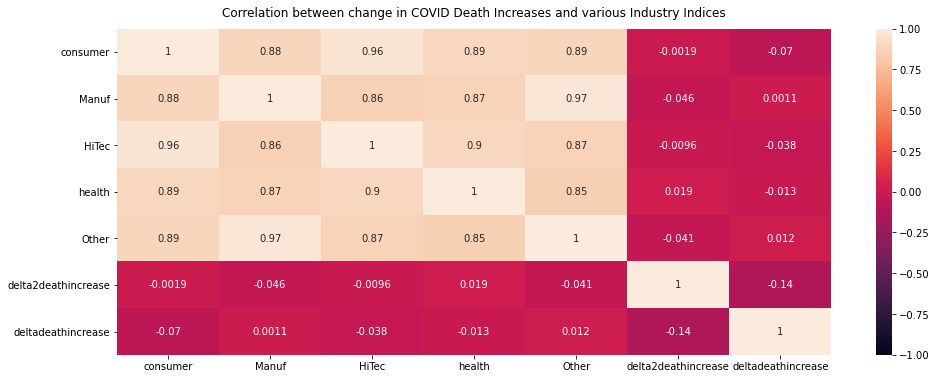

In [334]:
combined3 = combined.filter(['date','consumer','Manuf', 'HiTec', 'health', 'Other','delta2deathincrease', 'deltadeathincrease'])
corr = combined3.corr()
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
# fig.colorbar(cax)
# ticks = np.arange(0,len(combined3.columns),1)
# ax.set_xticks(ticks)
# plt.xticks(rotation=90)
# ax.set_yticks(ticks)
# ax.set_xticklabels(combined3.columns)
# ax.set_yticklabels(combined3.columns)
# plt.show()
#again, my matplotlib visualization broke and I'm not sure why. Here's a SNS visualization that does the same thing
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(combined3.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation between change in COVID Death Increases and various Industry Indices', fontdict={'fontsize':12}, pad=12);

Neither the correlations or the p values are strong between any of these measures and the industry indices. This reinforces the observation during the pandemic that the deaths perhaps don't really affect the stock market, given the record highs of the S&P contrasted to the high death rates.

# Question 2: We would still expect the stock market to respond in some way to COVID, but maybe death rates aren't the best indicator of financial markets. Can we predict behavior of indices with public opinion of COVID, as opposed to quantitative data on the pandemic? We will investigate this question by looking at Google Trends data

In [335]:
vaccine = pd.read_csv('vaccine-stats.csv', error_bad_lines=False)
vaccine = vaccine.drop(vaccine.index[0])

vaccine.reset_index(level=0, inplace=True)
vaccine = vaccine.rename(columns={vaccine.columns[0]: 'date'})
vaccine = vaccine.rename(columns={vaccine.columns[1]: 'searches'})
vaccine['date'] = pd.to_datetime(vaccine['date'])
vaccine['date'] = pd.DatetimeIndex(vaccine['date']) + pd.DateOffset(1)
vaccine = vaccine.set_index('date')
vaccine_join = combined.join(vaccine, on='date')
vaccine_join["searches"] = pd.to_numeric(vaccine_join["searches"], downcast="float")
vaccine_join = vaccine_join[vaccine_join['searches'].notna()]

vaccine_join

,date,consumer,Manuf,HiTec,health,Other,death,deathIncrease,inIcuCumulative,inIcuCurrently,...,onVentilatorCurrently,positive,positiveIncrease,recovered,states,totalTestResults,totalTestResultsIncrease,deltadeathincrease,delta2deathincrease,searches
24659,2020-01-27,-0.95,-1.54,-2.06,-0.29,-1.81,NaN,0.0,NaN,NaN,...,NaN,0.0,0.0,NaN,2.0,3.0,1.0,0.0,NaN,4.0
24664,2020-02-03,0.72,0.25,1.16,1.21,0.73,NaN,0.0,NaN,NaN,...,NaN,0.0,0.0,NaN,3.0,11.0,3.0,0.0,NaN,3.0
24669,2020-02-10,0.98,0.20,1.12,0.65,0.39,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,NaN,4.0,19.0,1.0,0.0,NaN,3.0
24678,2020-02-24,-3.05,-3.06,-3.79,-2.42,-3.63,0.0,0.0,NaN,NaN,...,NaN,0.0,0.0,NaN,5.0,40.0,2.0,0.0,-0.000000,13.0
24683,2020-03-02,4.39,4.04,4.58,4.21,4.15,11.0,3.0,NaN,NaN,...,NaN,94.0,44.0,NaN,11.0,6873.0,212.0,0.0,0.000000,15.0
24688,2020-03-09,-5.67,-10.04,-7.22,-5.67,-9.63,35.0,4.0,NaN,NaN,...,NaN,1112.0,285.0,NaN,51.0,14150.0,2189.0,2.0,-0.500000,32.0
24693,2020-03-16,-10.45,-11.59,-12.61,-9.74,-13.38,100.0,21.0,NaN,NaN,...,NaN,7772.0,1857.0,NaN,56.0,79281.0,24253.0,-3.0,0.428571,49.0
24698,2020-03-23,-0.60,-5.02,-0.90,-3.82,-4.75,582.0,101.0,NaN,NaN,...,NaN,51602.0,11435.0,NaN,56.0,363756.0,58237.0,-137.0,-inf,28.0
24703,2020-03-30,3.00,2.59,3.77,4.65,2.08,3425.0,588.0,187.0,3087.0,...,451.0,172740.0,21470.0,4560.0,56.0,1035705.0,116583.0,-319.0,3.288660,29.0
24708,2020-04-06,6.14,6.92,7.90,5.07,7.94,11932.0,1313.0,663.0,7079.0,...,2961.0,370872.0,28409.0,16557.0,56.0,2022867.0,151277.0,-731.0,-15.553191,24.0


Cleaning and preparing Google Trends data on the popularity of searches for "COVID-19 vaccine" in the US

In [336]:
vaccine_join = vaccine_join.filter(['date','consumer','Manuf', 'HiTec', 'health', 'Other','searches'])
vaccine_join.corr()

,consumer,Manuf,HiTec,health,Other,searches
consumer,1.000000,0.904207,0.981283,0.905916,0.927635,-0.349824
Manuf,0.904207,1.000000,0.889230,0.876513,0.984918,-0.316990
HiTec,0.981283,0.889230,1.000000,0.914344,0.913988,-0.350070
health,0.905916,0.876513,0.914344,1.000000,0.889743,-0.357535
Other,0.927635,0.984918,0.913988,0.889743,1.000000,-0.337576
searches,-0.349824,-0.316990,-0.350070,-0.357535,-0.337576,1.000000


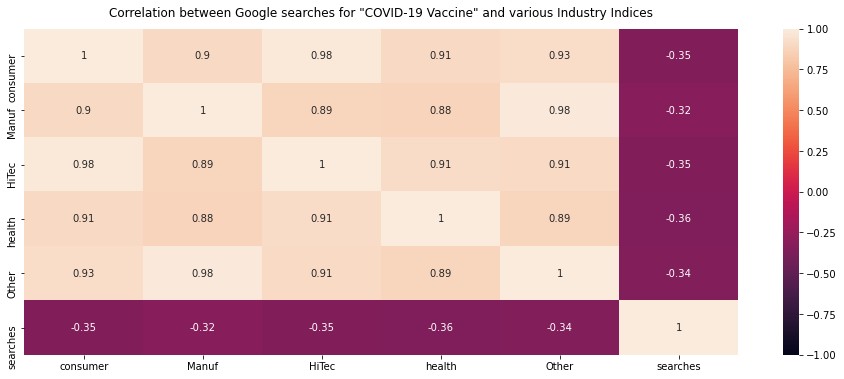

In [337]:
# corr = vaccine_join.corr()
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
# fig.colorbar(cax)
# ticks = np.arange(0,len(vaccine_join.columns),1)
# ax.set_xticks(ticks)
# plt.xticks(rotation=90)
# ax.set_yticks(ticks)
# ax.set_xticklabels(vaccine_join.columns)
# ax.set_yticklabels(vaccine_join.columns)
# plt.show()
# same as last two heatmaps
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(vaccine_join.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation between Google searches for "COVID-19 Vaccine" and various Industry Indices', fontdict={'fontsize':12}, pad=12);

Correlations between Google searches for "COVID-19 Vaccine" and the stock indices are immediately much higher than between COVID-19 deaths and the indices

In [338]:
import scipy.stats
manuf_search_r, manuf_search_p = scipy.stats.pearsonr(vaccine_join['Manuf'], vaccine_join['searches'])
consumer_search_r, consumer_search_p = scipy.stats.pearsonr(vaccine_join['consumer'], vaccine_join['searches'])
hitec_search_r, hitec_search_p = scipy.stats.pearsonr(vaccine_join['HiTec'], vaccine_join['searches'])
health_search_r, health_search_p = scipy.stats.pearsonr(vaccine_join['health'], vaccine_join['searches'])
other_search_r, other_search_p = scipy.stats.pearsonr(vaccine_join['Other'], vaccine_join['searches'])

In [339]:
print ("P value for manufacturing is: ", manuf_search_p)
print ("P value for consumer is: ", consumer_search_p)
print ("P value for high tech is: ", hitec_search_p)
print ("P value for health is: ", health_search_p)
print ("P value for health is: ", other_search_p)

P value for manufacturing is:  0.05592495067816227
P value for consumer is:  0.033801084447746196
P value for high tech is:  0.03366751263041661
P value for health is:  0.029815245720317105
P value for health is:  0.0410193612189759


All of these P values are low, indicating a high possibility of a correlation. However, it is interesting to note that the magnitude of the correlations are all similar, with no distinctly different impact on one sector over the others (one might expect health to be most strongly, for example). All correlations are negative as well, which is interesting, as one might expect more news about vaccines to lead to upticks in the stock market.

In [340]:
covid_19 = pd.read_csv('covid-19-stats.csv', error_bad_lines=False)
covid_19 = vaccine.drop(vaccine.index[0])

covid_19.reset_index(level=0, inplace=True)
covid_19 = covid_19.rename(columns={covid_19.columns[0]: 'date'})
covid_19 = covid_19.rename(columns={covid_19.columns[1]: 'searches'})
covid_19['date'] = pd.to_datetime(covid_19['date'])
covid_19['date'] = pd.DatetimeIndex(covid_19['date']) + pd.DateOffset(1)
#this offset is necessary because google trends is every sunday 
#while index trends are not on sundays 
covid_19 = covid_19.set_index('date')
covid_19_join = combined.join(covid_19, on='date')
covid_19_join["searches"] = pd.to_numeric(covid_19_join["searches"], downcast="float")

covid_19_join = covid_19_join[covid_19_join['searches'].notna()]


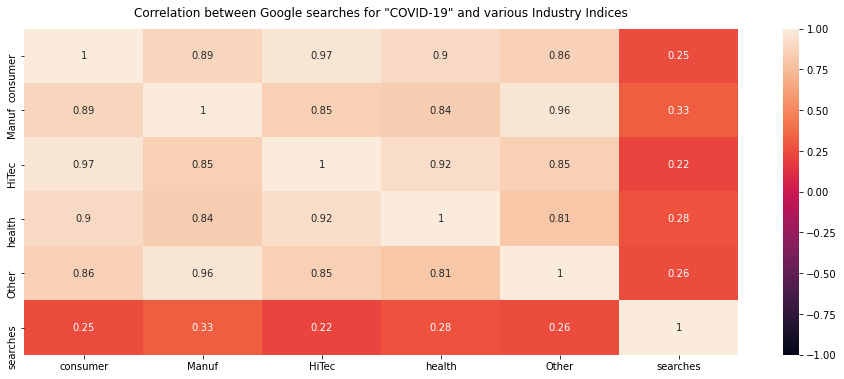

In [341]:
covid_19_join = covid_19_join.filter(['date','consumer','Manuf', 'HiTec', 'health', 'Other','searches'])
# corr = covid_19_join.corr()
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
# fig.colorbar(cax)
# ticks = np.arange(0,len(vaccine_join.columns),1)
# ax.set_xticks(ticks)
# plt.xticks(rotation=90)
# ax.set_yticks(ticks)
# ax.set_xticklabels(vaccine_join.columns)
# ax.set_yticklabels(vaccine_join.columns)
# plt.show()
# same as previous two - this visualization broke so I did it in seaborn

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(covid_19_join.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation between Google searches for "COVID-19" and various Industry Indices', fontdict={'fontsize':12}, pad=12);

In [342]:
import scipy.stats
manuf_covid_search_r, manuf_covid_search_p = scipy.stats.pearsonr(covid_19_join['Manuf'], covid_19_join['searches'])
consumer_covid_search_r, consumer_covid_search_p = scipy.stats.pearsonr(covid_19_join['consumer'], covid_19_join['searches'])
hitec_covid_search_r, hitec_covid_search_p = scipy.stats.pearsonr(covid_19_join['HiTec'], covid_19_join['searches'])
health_covid_search_r, health_covid_search_p = scipy.stats.pearsonr(covid_19_join['health'], covid_19_join['searches'])
other_covid_search_r, other_covid_search_p = scipy.stats.pearsonr(covid_19_join['Other'], covid_19_join['searches'])
print ("P value for manufacturing is: ", manuf_covid_search_p)
print ("P value for consumer is: ", consumer_covid_search_p)
print ("P value for high tech is: ", hitec_covid_search_p)
print ("P value for health is: ", health_covid_search_p)
print ("P value for health is: ", other_covid_search_p)

P value for manufacturing is:  0.039985413126394496
P value for consumer is:  0.11456209817451413
P value for high tech is:  0.1688826720428412
P value for health is:  0.08154265584897492
P value for health is:  0.10946594575383622


The correlation between searches for "COVID-19" and the indices is of a smaller degree than "COVID-19 Vaccine", positive instead of negative, and has larger P values. To prevent P-hacking, we picked these two specific search terms to analyze beforehand and did not leave out any other correlation analysis.

# Question 3: Are confounding factors causing the correlation between Google searches and the indices? 

To gauge the possibility of confounding factors, we are going to examine the correlation of the data with two control group, in this case the 2008/2011 US recessions (caused by the housing crisis and the Euro crisis). This helps us examine whether there is some outside factor unaccounted for - for example, perhaps the shape of the Google Trends data coincidentally matches the normal shape of the stock market during a recession. If there is a low P-value between these trends and these recessions where there was no COVID, it would indicate that the correlation is likely caused by some confounding variable

# Question 3a) The Euro Crisis

In [343]:
MEUR = industry[industry['date'].dt.year == 2011]
meurcontrol = MEUR

meurcontrol['date'] = pd.DatetimeIndex(MEUR['date']) + pd.DateOffset(years = 9)

#again, this is to make merging the data easier. 
mask = (meurcontrol['date'] > '2020-1-27') & (meurcontrol['date'] <= '2020-10-28')
#filtering for the dates in the 2020 dataset
meurcontrol = (meurcontrol.loc[mask])
meurcontrol['date'] = pd.DatetimeIndex(meurcontrol['date']) + pd.DateOffset(1)
#offset of two because the days of week need to line up
meur_vaccine_join = meurcontrol.join(vaccine, on='date')
meur_vaccine_join["searches"] = pd.to_numeric(meur_vaccine_join["searches"], downcast="float")
meur_vaccine_join = meur_vaccine_join[meur_vaccine_join['searches'].notna()]

<ipython-input-343-f5007df0d461>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meurcontrol['date'] = pd.DatetimeIndex(MEUR['date']) + pd.DateOffset(years = 9)
<ipython-input-343-f5007df0d461>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meurcontrol['date'] = pd.DatetimeIndex(meurcontrol['date']) + pd.DateOffset(1)


In [344]:
meur_vaccine_join.corr()

,consumer,Manuf,HiTec,health,Other,searches
consumer,1.000000,0.919177,0.959284,0.917024,0.932144,0.114442
Manuf,0.919177,1.000000,0.933654,0.901830,0.918984,0.041710
HiTec,0.959284,0.933654,1.000000,0.906481,0.917323,0.054267
health,0.917024,0.901830,0.906481,1.000000,0.879432,0.064651
Other,0.932144,0.918984,0.917323,0.879432,1.000000,0.133327
searches,0.114442,0.041710,0.054267,0.064651,0.133327,1.000000


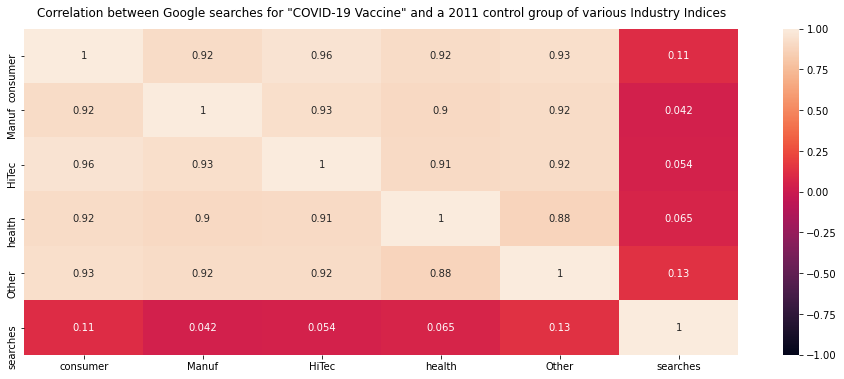

In [345]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(meur_vaccine_join.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation between Google searches for "COVID-19 Vaccine" and a 2011 control group of various Industry Indices', fontdict={'fontsize':12}, pad=12);

In [346]:
meur_manuf_search_r, meur_manuf_search_p = scipy.stats.pearsonr(meur_vaccine_join['Manuf'], meur_vaccine_join['searches'])
meur_consumer_search_r, meur_consumer_search_p = scipy.stats.pearsonr(meur_vaccine_join['consumer'], meur_vaccine_join['searches'])
meur_hitec_search_r, meur_hitec_search_p = scipy.stats.pearsonr(meur_vaccine_join['HiTec'], meur_vaccine_join['searches'])
meur_health_search_r, meur_health_search_p = scipy.stats.pearsonr(meur_vaccine_join['health'], meur_vaccine_join['searches'])
meur_other_search_r, meur_other_search_p = scipy.stats.pearsonr(meur_vaccine_join['Other'], meur_vaccine_join['searches'])

In [347]:
print ("P value for manufacturing is: ", meur_manuf_search_p)
print ("P value for consumer is: ", meur_consumer_search_p)
print ("P value for high tech is: ", meur_hitec_search_p)
print ("P value for health is: ", meur_health_search_p)
print ("P value for health is: ", meur_other_search_p)

P value for manufacturing is:  0.8009527491928099
P value for consumer is:  0.4878564261657712
P value for high tech is:  0.7428252703046058
P value for health is:  0.6957830136254716
P value for health is:  0.4184234866970589


In [348]:
meur2 = industry
meur2['date'] = pd.DatetimeIndex(meur2['date']) + pd.DateOffset(3094)
mask = (meur2['date'] > '2020-1-27') & (meur2['date'] <= '2020-10-28')
#3094 days between the start of the 2011 US stock market crash and the start of the COVID-19 Market crash

meur2 = (meur2.loc[mask])

meur_vaccine_join = meur2.join(vaccine, on='date')
meur_vaccine_join["searches"] = pd.to_numeric(meur_vaccine_join["searches"], downcast="float")
meur_vaccine_join = meur_vaccine_join[meur_vaccine_join['searches'].notna()]

In [349]:
meur_vaccine_join.corr()

,consumer,Manuf,HiTec,health,Other,searches
consumer,1.000000,0.957784,0.962347,0.952854,0.963421,-0.047401
Manuf,0.957784,1.000000,0.950972,0.951427,0.976973,-0.001138
HiTec,0.962347,0.950972,1.000000,0.941522,0.951234,-0.074499
health,0.952854,0.951427,0.941522,1.000000,0.947849,-0.135498
Other,0.963421,0.976973,0.951234,0.947849,1.000000,-0.033643
searches,-0.047401,-0.001138,-0.074499,-0.135498,-0.033643,1.000000


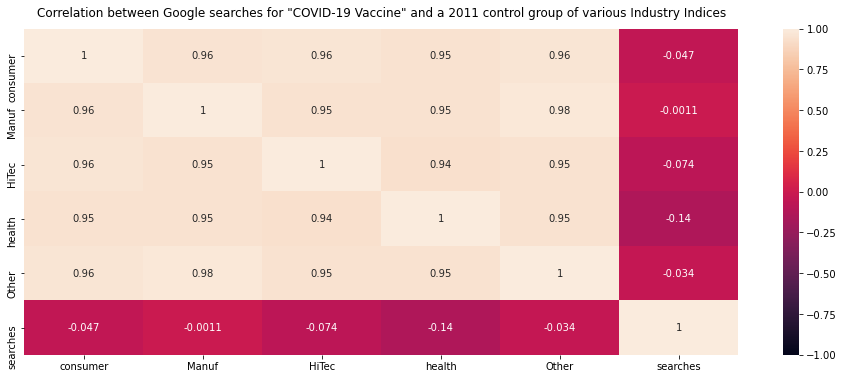

In [350]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(meur_vaccine_join.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation between Google searches for "COVID-19 Vaccine" and a 2011 control group of various Industry Indices', fontdict={'fontsize':12}, pad=12);

In [351]:
meur_manuf_search_r, meur_manuf_search_p = scipy.stats.pearsonr(meur_vaccine_join['Manuf'], meur_vaccine_join['searches'])
meur_consumer_search_r, meur_consumer_search_p = scipy.stats.pearsonr(meur_vaccine_join['consumer'], meur_vaccine_join['searches'])
meur_hitec_search_r, meur_hitec_search_p = scipy.stats.pearsonr(meur_vaccine_join['HiTec'], meur_vaccine_join['searches'])
meur_health_search_r, meur_health_search_p = scipy.stats.pearsonr(meur_vaccine_join['health'], meur_vaccine_join['searches'])
meur_other_search_r, meur_other_search_p = scipy.stats.pearsonr(meur_vaccine_join['Other'], meur_vaccine_join['searches'])

In [352]:
print ("P value for manufacturing is: ", meur_manuf_search_p)
print ("P value for consumer is: ", meur_consumer_search_p)
print ("P value for high tech is: ", meur_hitec_search_p)
print ("P value for health is: ", meur_health_search_p)
print ("P value for health is: ", meur_other_search_p)

P value for manufacturing is:  0.9949024119030181
P value for consumer is:  0.7900823078420238
P value for high tech is:  0.6754087389989661
P value for health is:  0.44483062329478323
P value for health is:  0.8501811037293296


# Question 3b) Global Financial Crisis

In [353]:
gfc = industry[industry['date'].dt.year == 2008]
gfccontrol = gfc

gfccontrol['date'] = pd.DatetimeIndex(gfc['date']) + pd.DateOffset(years = 12)
#again, this is to make merging the data easier. 
mask = (gfccontrol['date'] > '2020-1-27') & (gfccontrol['date'] <= '2020-10-28')
#filtering for the dates in the 2020 dataset
gfccontrol = (gfccontrol.loc[mask])
gfccontrol['date'] = pd.DatetimeIndex(gfccontrol['date']) + pd.DateOffset(2)
#offset because the days of week need to line up
gfc_vaccine_join = gfccontrol.join(vaccine, on='date')
gfc_vaccine_join["searches"] = pd.to_numeric(gfc_vaccine_join["searches"], downcast="float")
gfc_vaccine_join = gfc_vaccine_join[gfc_vaccine_join['searches'].notna()]

<ipython-input-353-fa126a0f598d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gfccontrol['date'] = pd.DatetimeIndex(gfc['date']) + pd.DateOffset(years = 12)
<ipython-input-353-fa126a0f598d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gfccontrol['date'] = pd.DatetimeIndex(gfccontrol['date']) + pd.DateOffset(2)


In [354]:
gfc_vaccine_join.corr()

,consumer,Manuf,HiTec,health,Other,searches
consumer,1.000000,0.888627,0.802294,0.694194,0.870072,-0.189591
Manuf,0.888627,1.000000,0.829342,0.673827,0.844577,-0.257511
HiTec,0.802294,0.829342,1.000000,0.573718,0.786756,-0.197005
health,0.694194,0.673827,0.573718,1.000000,0.566212,-0.116514
Other,0.870072,0.844577,0.786756,0.566212,1.000000,-0.226700
searches,-0.189591,-0.257511,-0.197005,-0.116514,-0.226700,1.000000


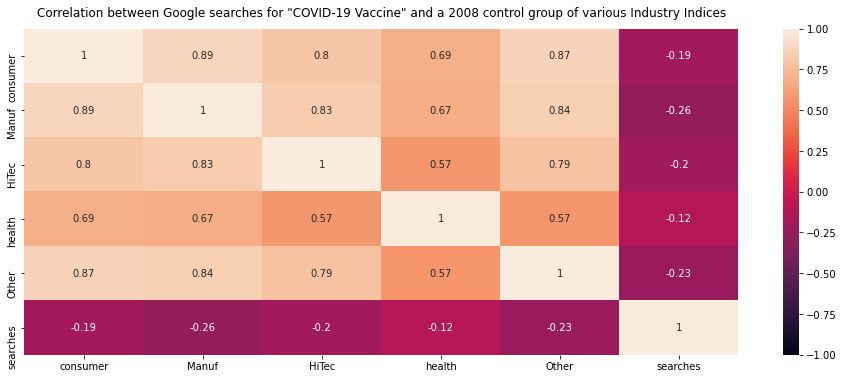

In [355]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(gfc_vaccine_join.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation between Google searches for "COVID-19 Vaccine" and a 2008 control group of various Industry Indices', fontdict={'fontsize':12}, pad=12);

In [356]:
gfc_manuf_search_r, gfc_manuf_search_p = scipy.stats.pearsonr(gfc_vaccine_join['Manuf'], gfc_vaccine_join['searches'])
gfc_consumer_search_r, gfc_consumer_search_p = scipy.stats.pearsonr(gfc_vaccine_join['consumer'], gfc_vaccine_join['searches'])
gfc_hitec_search_r, gfc_hitec_search_p = scipy.stats.pearsonr(gfc_vaccine_join['HiTec'], gfc_vaccine_join['searches'])
gfc_health_search_r, gfc_health_search_p = scipy.stats.pearsonr(gfc_vaccine_join['health'], gfc_vaccine_join['searches'])
gfc_other_search_r,gfc_other_search_p = scipy.stats.pearsonr(gfc_vaccine_join['Other'], gfc_vaccine_join['searches'])

In [357]:
print ("P value for manufacturing is: ", gfc_manuf_search_p)
print ("P value for consumer is: ", gfc_consumer_search_p)
print ("P value for high tech is: ", gfc_hitec_search_p)
print ("P value for health is: ", gfc_health_search_p)
print ("P value for health is: ", gfc_other_search_p)

P value for manufacturing is:  0.12387829889880168
P value for consumer is:  0.2610625076152162
P value for high tech is:  0.2425227187470856
P value for health is:  0.49224164754387206
P value for health is:  0.17724892433707834


In [358]:
gfc2 = industry
gfc2['date'] = pd.DatetimeIndex(gfc2['date']) + pd.DateOffset(4150)
mask = (gfc2['date'] > '2020-1-27') & (gfc2['date'] <= '2020-10-28')
#4150 days between the start of the 2008 US stock market crash and the start of the COVID-19 Market crash

gfc2 = (gfc2.loc[mask])

gfc_vaccine_join = gfc2.join(vaccine, on='date')
gfc_vaccine_join["searches"] = pd.to_numeric(gfc_vaccine_join["searches"], downcast="float")
gfc_vaccine_join = gfc_vaccine_join[gfc_vaccine_join['searches'].notna()]

In [359]:
gfc_vaccine_join.corr()

,consumer,Manuf,HiTec,health,Other,searches
consumer,1.000000,0.479713,0.445559,0.181513,0.612851,-0.156904
Manuf,0.479713,1.000000,0.355509,0.306615,0.455949,-0.189400
HiTec,0.445559,0.355509,1.000000,0.251323,0.691197,-0.040326
health,0.181513,0.306615,0.251323,1.000000,0.163966,-0.276614
Other,0.612851,0.455949,0.691197,0.163966,1.000000,-0.135216
searches,-0.156904,-0.189400,-0.040326,-0.276614,-0.135216,1.000000


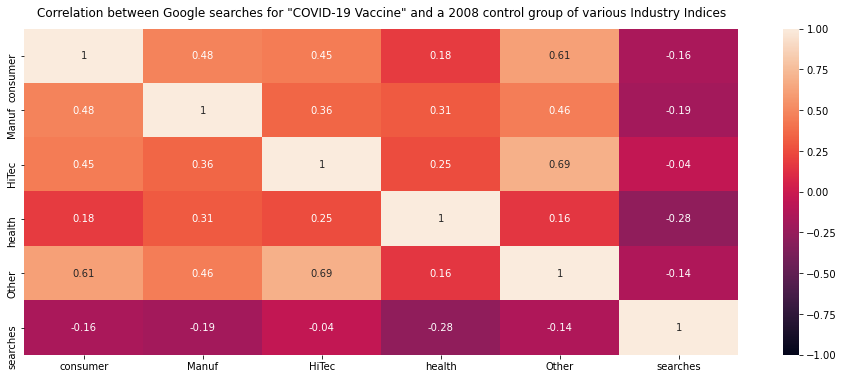

In [360]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(gfc_vaccine_join.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation between Google searches for "COVID-19 Vaccine" and a 2008 control group of various Industry Indices', fontdict={'fontsize':12}, pad=12);

In [361]:
gfc_manuf_search_r, gfc_manuf_search_p = scipy.stats.pearsonr(gfc_vaccine_join['Manuf'], gfc_vaccine_join['searches'])
gfc_consumer_search_r, gfc_consumer_search_p = scipy.stats.pearsonr(gfc_vaccine_join['consumer'], gfc_vaccine_join['searches'])
gfc_hitec_search_r, gfc_hitec_search_p = scipy.stats.pearsonr(gfc_vaccine_join['HiTec'], gfc_vaccine_join['searches'])
gfc_health_search_r, gfc_health_search_p = scipy.stats.pearsonr(gfc_vaccine_join['health'], gfc_vaccine_join['searches'])
gfc_other_search_r,gfc_other_search_p = scipy.stats.pearsonr(gfc_vaccine_join['Other'], gfc_vaccine_join['searches'])

In [362]:
print ("P value for manufacturing is: ", gfc_manuf_search_p)
print ("P value for consumer is: ", gfc_consumer_search_p)
print ("P value for high tech is: ", gfc_hitec_search_p)
print ("P value for health is: ", gfc_health_search_p)
print ("P value for health is: ", gfc_other_search_p)

P value for manufacturing is:  0.25475147321916447
P value for consumer is:  0.3468299037396982
P value for high tech is:  0.8100380825275967
P value for health is:  0.09272670968012994
P value for health is:  0.4182806701750784


# Question 3: Analysis

We analyzed vs control groups of the 2008 and 2011 financial market crashes. In both, we shifted them two ways: first, by looking at data from Jan. 27 - October 28 of the respective years, and also by looking at the first ten months of each recession (the same time period that we have for the 2020 recession). This is to investigate potentially confounding relationships between the Google search, these indices, and time based values or the natural shape of a recession (perhaps the search trends simply match the normal curve of a recession, or coincide with normal monthly stock market trends).

Looking at the P values - none of them in any scenario are as low as the ones from 2020. Additionally, the R values were lower as well. This is encouraging, as it eliminates a few sources of confounding and strengthens the connection between the Google searches for "COVID-19 Vaccine" and the change in market indices. We expect the same to hold true for the Google searches for "COVID-19", as the same potential confounding factors should be ruled out.

Potential confounding still exists. however, many general potential sources of it involving the general nature/shape of recessions can likely be eliminated. 


# Question 4: A deeper dive into specific companies and financial analysis

In [363]:
industry['date'] = pd.to_datetime(industry['date'], format='%Y%m%d')
national['date'] = pd.to_datetime(national['date'])
ind_cov = industry[industry['date'].dt.year == 2020]
ind_rec = industry.iloc[21602:21999, 0:5]
ind_eur = industry.iloc[22127:22881, 0:5]
combined = industry
combined = combined.join(national.set_index('date'), on='date')
combined = combined[combined['deathIncrease'].notna()]


In [364]:
cov_di = combined['deathIncrease']
cov_hi = combined['hospitalizedIncrease']
cov_pi = combined['positiveIncrease']
national_reg = national.iloc[::-1]
national_reg 

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,recovered,states,totalTestResults,totalTestResultsIncrease
319,2020-01-22,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,1,0
318,2020-01-23,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,1
317,2020-01-24,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
316,2020-01-25,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
315,2020-01-26,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,2020-12-02,264522.0,2733,31038.0,19680.0,5028,100322.0,570121.0,156787587,982032,3252.0,6855.0,13711156,195796,5322128.0,56,196576482,1459202
3,2020-12-03,267228.0,2706,31276.0,19723.0,5331,100755.0,575452.0,158026052,1238465,3280.0,6867.0,13921360,210204,5404018.0,56,198404712,1828230
2,2020-12-04,269791.0,2563,31608.0,19858.0,4652,101276.0,580104.0,159286709,1260657,3305.0,6999.0,14146191,224831,5470389.0,56,200259581,1854869
1,2020-12-05,272236.0,2445,31831.0,19950.0,3316,101190.0,583420.0,160813704,1526995,3321.0,7005.0,14357264,211073,5576026.0,56,202429337,2169756


#### In the line above, we looked at individual columns of the COVID-19 data as well as flipped the order of the data so it matches our stock market data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<function matplotlib.pyplot.show(*args, **kw)>

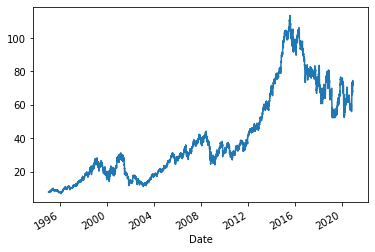

In [365]:
cvs = yf.download('CVS','1995-01-01','2020-12-12')
cvs_cov = yf.download('CVS','2020-01-01','2020-12-12')
cvs_eur = yf.download('CVS','2010-01-01','2012-12-31')
cvs_rec = yf.download('CVS','2007-12-01','2009-06-30')
cvs.Close.plot()
plt.show

#### In the above line, we download stock market data from CVS (healthcare industry) from Yahoo finance in a cumulative view (1995-2020) as well as different economic downturns such as the great recession (2007 - 2009), the European Debt Crisis (2010 - 2012) and the COVID-19 pandemic (2020). We graph the close price per trading day for the cumulative view of CVS above. This gives us a deeper look into a specific healthcare related company instead of looking at the general index for the healthcare industry. 

In [366]:
cvs_eur.describe()
cvs_rec.describe()
cvs_cov.describe()

,Open,High,Low,Close,Adj Close,Volume
count,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02
mean,64.013750,64.882125,63.094750,63.996167,63.059918,8.845602e+06
std,5.286630,5.098838,5.355556,5.254454,5.099349,4.236427e+06
min,53.630001,54.970001,52.040001,52.299999,51.031059,2.803700e+06
25%,59.772499,60.574999,59.209999,59.670000,59.083695,6.059400e+06
50%,63.795000,64.230000,62.850000,63.655001,62.720898,7.538300e+06
75%,67.287498,68.187502,66.402502,66.869999,66.242796,1.012930e+07
max,76.110001,76.440002,75.830002,76.050003,74.500000,3.442970e+07


In [367]:
cvs_cov.iloc[30:180, 0:5]

,Open,High,Low,Close,Adj Close
Date,,,,,
2020-02-14,71.980003,72.029999,70.269997,71.370003,69.638367
2020-02-18,71.190002,72.000000,70.900002,72.000000,70.253082
2020-02-19,72.309998,72.559998,71.660004,71.779999,70.038414
2020-02-20,71.500000,72.230003,70.559998,71.940002,70.194542
2020-02-21,71.550003,71.800003,71.010002,71.510002,69.774971
...,...,...,...,...,...
2020-09-11,58.130001,58.139999,57.060001,57.400002,56.917080
2020-09-14,57.630001,58.209999,57.549999,57.970001,57.482285
2020-09-15,58.000000,58.610001,56.990002,57.000000,56.520443


#### The COVID-19 pandemic yielded the lowest standard deviation of stock prices (at close) compared to other economic downturns. this is expected for CVS as a healthcare company as a virus induced pandemic would see constant demand for CVS services. It is important to note though that comparing the February stock price for CVS with September prices we see a difference of much more than two standard deviations from the mean in both cases. Thus, the COVID-19 period is still a highly volatile time for CVS, as shown on the plot below. 

<function matplotlib.pyplot.show(*args, **kw)>

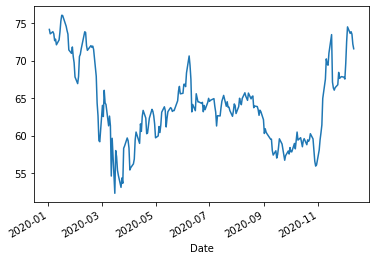

In [368]:
cvs_cov.Close.plot()
plt.show

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<function matplotlib.pyplot.show(*args, **kw)>

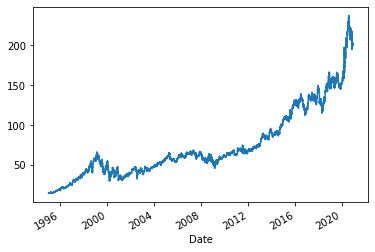

In [369]:
clx = yf.download('CLX','1995-01-01','2020-12-12')
clx_cov = yf.download('CLX','2020-01-01','2020-12-12')
clx_eur = yf.download('CLX','2010-01-01','2012-12-31')
clx_rec = yf.download('CLX','2007-12-01','2009-06-30')
clx.Close.plot()
plt.show

#### We also wanted to look at The Clorox Company as we thought it would yield interesting results given the high demand for its products during the COVID-19 pandemic. The process we used for CVS is repeated here. From first glance from this cumulative plot, it seems that The Clorox Company saw much more drastic increases in stock price during the COVID-19 pandemic compared with CVS. 

In [370]:
clx_eur.describe()
clx_rec.describe()
clx_cov.describe()

,Open,High,Low,Close,Adj Close,Volume
count,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02
mean,198.647125,201.285250,196.313374,198.726708,196.928154,1.757035e+06
std,23.457422,23.427932,23.459126,23.359126,23.947761,1.067079e+06
min,151.779999,153.009995,150.949997,151.520004,148.196564,4.895000e+05
25%,177.597504,182.327496,173.947498,177.504993,174.769737,1.070150e+06
50%,204.534996,207.480003,202.629997,204.589996,203.063934,1.498700e+06
75%,215.547504,218.002499,213.162502,215.025005,213.870422,2.084550e+06
max,238.190002,239.869995,235.610001,237.740005,236.518463,7.478700e+06


In [371]:
clx_cov.iloc[30:180, 0:5]

,Open,High,Low,Close,Adj Close
Date,,,,,
2020-02-14,164.990005,165.100006,164.190002,164.830002,162.290070
2020-02-18,165.259995,165.360001,163.860001,164.820007,162.280228
2020-02-19,165.000000,165.720001,164.100006,164.839996,162.299911
2020-02-20,164.729996,164.970001,163.589996,164.169998,161.640228
2020-02-21,163.690002,165.270004,163.690002,164.639999,162.102997
...,...,...,...,...,...
2020-09-11,215.479996,216.419998,212.119995,214.000000,212.900436
2020-09-14,214.490005,217.929993,213.500000,217.460007,216.342667
2020-09-15,215.679993,216.389999,208.679993,209.589996,208.513092


#### While the European Debt Crisis and the great recession yielded standard deviations of 3.8 and 4.2 respectively, COVID-19 standard deviation for The Clorox Company was significantly higher at 23.4 (all figures are for close prices). This increased volatility is not surprising as demand for products from the company increased heavily during the pandemic. For example, the close price in February compared to September (shown above) was vastly different. This tells us that while economic downturns affects the entire stock market, the causes of such downturns still creats winners in each unique case. The Clorox Company, compared with other economic downturns, was positively impacted by the COVID-19 crisis and saw its volatility translate into signficant gains for the company. A plot below is shown to highlight these gains. 

<function matplotlib.pyplot.show(*args, **kw)>

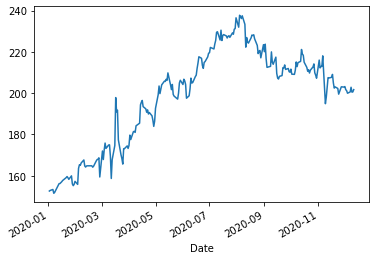

In [372]:
clx_cov.Close.plot()
plt.show

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<function matplotlib.pyplot.show(*args, **kw)>

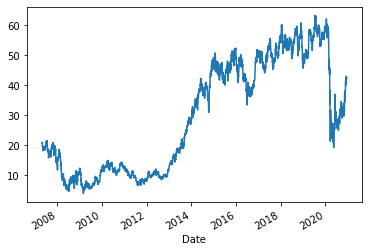

In [373]:
dal = yf.download('DAL','1995-01-01','2020-12-12')
dal_cov = yf.download('DAL','2020-01-01','2020-12-12')
dal_eur = yf.download('DAL','2010-01-01','2012-12-31')
dal_rec = yf.download('DAL','2007-12-01','2009-06-30')
dal.Close.plot()
plt.show

#### Finally, we wanted to look at Delta Airlines as airlines are traditionally hit the hardest as a part of this pandemic. The process we used for CVS and The Clorox Company is repeated here. From this cumulative plot, we can see that while 2008 and 2012 showed declines in stock price, Delta Airlines was hit the hardest in 2020 with the steepest drop. 

In [374]:
dal_eur.describe()
dal_rec.describe()
dal_cov.describe()

,Open,High,Low,Close,Adj Close,Volume
count,240.000000,240.000000,240.000000,240.000000,240.000000,2.400000e+02
mean,34.814375,35.573667,33.828333,34.681792,34.628023,3.085508e+07
std,11.765146,11.729216,11.797150,11.787662,11.677469,2.395423e+07
min,18.799999,19.540001,17.510000,19.190001,19.190001,3.810100e+06
25%,26.650000,27.295000,25.925000,26.702500,26.702500,1.454168e+07
50%,30.925000,31.565001,30.125000,30.835000,30.835000,2.233950e+07
75%,39.870001,41.052500,39.132501,40.032499,40.032499,4.244268e+07
max,62.130001,62.480000,61.869999,62.029999,61.604282,1.346265e+08


In [375]:
dal_cov.iloc[30:180, 0:5]

,Open,High,Low,Close,Adj Close
Date,,,,,
2020-02-14,59.240002,59.470001,58.580002,58.900002,58.495766
2020-02-18,58.869999,59.470001,58.410000,58.720001,58.317001
2020-02-19,58.490002,58.580002,58.029999,58.509998,58.509998
2020-02-20,58.200001,58.990002,58.119999,58.380001,58.380001
2020-02-21,57.959999,58.020000,56.869999,57.869999,57.869999
...,...,...,...,...,...
2020-09-11,31.809999,32.130001,31.340000,31.700001,31.700001
2020-09-14,32.290001,32.900002,32.009998,32.820000,32.820000
2020-09-15,33.200001,34.480000,33.099998,33.509998,33.509998


#### Once again, the volatility of the stock price is significantly higher during the COVID-19 period compared with the other economic downturns. This once again shows that specific causes of economic downturns affect different companies. In this case, the volatility increase from COVID-19 in comparison with other recessions is a consequence of significant losses as opposed to gains. As shown above, the stock price for Delta Airlines in February was close to double what is was in September. A plot below will highlight the losses.

<function matplotlib.pyplot.show(*args, **kw)>

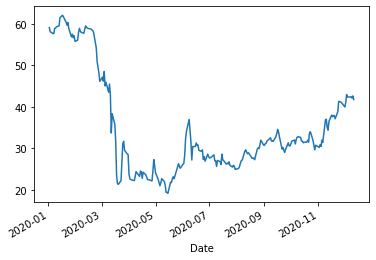

In [376]:
dal_cov.Close.plot()
plt.show

# Multiple Linear Regression Analysis

#### To further explore the relationship between these specific companies and the COVID-19 pandemic, we ran regressions on the COVID-19 stock market data versus different predictor variables from the national COVID-19 data. 

In [377]:
cvs_reg = pd.merge(left=national_reg, left_on='date', right=cvs_cov, right_on='Date') 
cvs_reg

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,...,recovered,states,totalTestResults,totalTestResultsIncrease,Open,High,Low,Close,Adj Close,Volume
0,2020-01-22,NaN,0,NaN,NaN,0,NaN,NaN,0,0,...,NaN,2,1,0,74.160004,74.620003,73.910004,74.010002,72.214317,4201400
1,2020-01-23,NaN,0,NaN,NaN,0,NaN,NaN,0,0,...,NaN,2,2,1,73.760002,73.879997,72.480003,73.529999,71.745956,8602500
2,2020-01-24,NaN,0,NaN,NaN,0,NaN,NaN,0,0,...,NaN,2,2,0,73.639999,73.650002,70.169998,71.430000,69.696915,10126000
3,2020-01-27,NaN,0,NaN,NaN,0,NaN,NaN,0,0,...,NaN,2,3,1,69.900002,71.209999,69.360001,70.970001,69.248070,6403300
4,2020-01-28,NaN,0,NaN,NaN,0,NaN,NaN,0,0,...,NaN,2,3,0,71.250000,72.139999,71.120003,71.820000,70.077446,5039100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2020-11-30,259316.0,1136,30469.0,18801.0,3394,96149.0,559871.0,153863841,1219808,...,5146643.0,56,192776284,1603253,67.809998,68.089996,67.199997,67.790001,67.790001,8242600
218,2020-12-01,261789.0,2473,30749.0,19295.0,5222,98777.0,565093.0,155805555,1941714,...,5226581.0,56,195117280,2340996,68.389999,69.330002,67.360001,67.540001,67.540001,8239700
219,2020-12-02,264522.0,2733,31038.0,19680.0,5028,100322.0,570121.0,156787587,982032,...,5322128.0,56,196576482,1459202,67.550003,70.290001,67.449997,69.629997,69.629997,8138500
220,2020-12-03,267228.0,2706,31276.0,19723.0,5331,100755.0,575452.0,158026052,1238465,...,5404018.0,56,198404712,1828230,69.709999,72.629997,69.230003,72.519997,72.519997,13270200


#### Because the stock market data and COVID-19 data starts on different dates and do not match (stock market data is only trading days while COVID-19 data is not), we merged them so that only the matching dates for both datasets are used. 

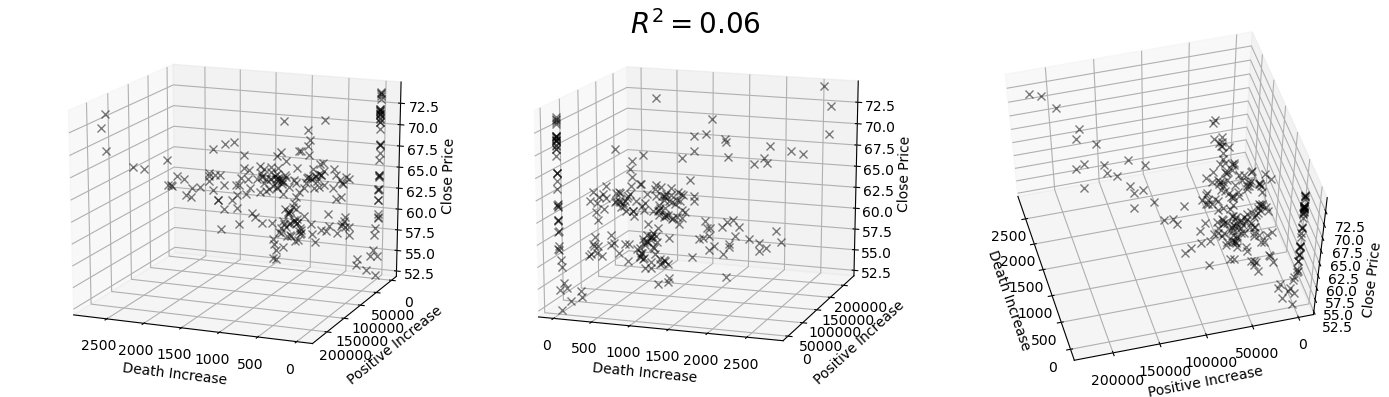

In [378]:
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D

X = cvs_reg[['deathIncrease', 'positiveIncrease']].values.reshape(-1,2)
Y = cvs_reg['Close']

x = X[:, 0]
y = X[:, 1]
z = Y

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)

r2 = model.score(X, Y)

plt.style.use('default')

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='black', zorder=14, linestyle='none', marker='x', alpha=0.5)
    ax.set_xlabel('Death Increase', fontsize=10)
    ax.set_ylabel('Positive Increase', fontsize=10)
    ax.set_zlabel('Close Price', fontsize=10)

ax1.view_init(elev=17, azim=112)
ax2.view_init(elev=16, azim=-71)
ax3.view_init(elev=55, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

In [379]:
model.coef_

array([-1.45625532e-03,  2.81835652e-05])

#### As shown above, we used number of death and positive case increases as predictor variables for the close price of CVS during the COVID-19 pandemic. A multiple linear regression was used. We find the coefficients to be, whether negative or positive, very close to zero and thus we conclude very limited predictive power. In the visualization of this regression, we also see an extremely small r-squared value which indicated no predictive power. This is surprising for us as we would have expected increased deaths from covid to drive sales of drugs and other medical supplies in CVS. However, it is possible that the economic lockdown had a more signnificant effect instead. 

In [380]:
clx_reg = pd.merge(left=national_reg, left_on='date', right=clx_cov, right_on='Date') 

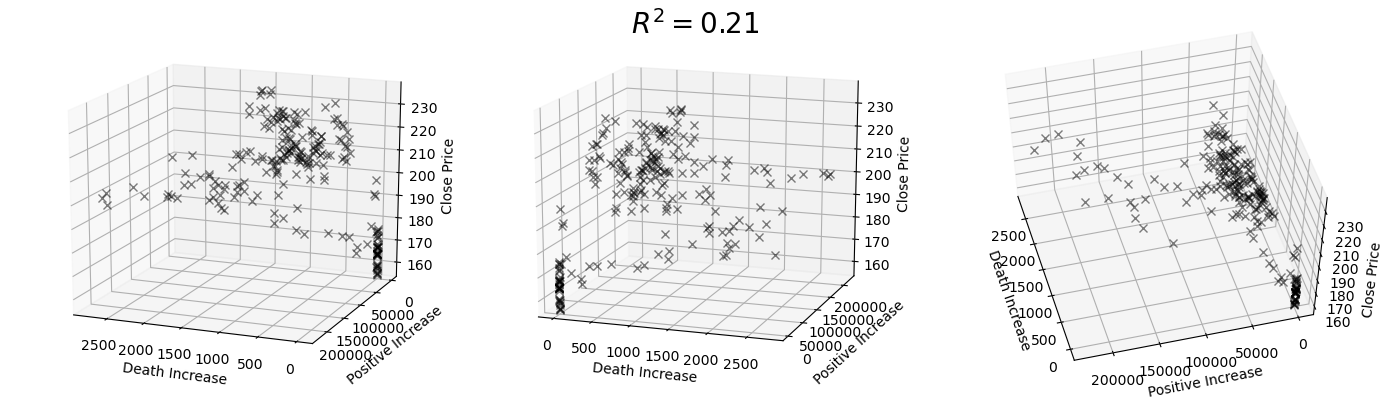

In [381]:
X = clx_reg[['deathIncrease', 'positiveIncrease']].values.reshape(-1,2)
Y = clx_reg['Close']

x = X[:, 0]
y = X[:, 1]
z = Y

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)

r2 = model.score(X, Y)

plt.style.use('default')

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='black', zorder=14, linestyle='none', marker='x', alpha=0.5)
    ax.set_xlabel('Death Increase', fontsize=10)
    ax.set_ylabel('Positive Increase', fontsize=10)
    ax.set_zlabel('Close Price', fontsize=10)

ax1.view_init(elev=17, azim=112)
ax2.view_init(elev=16, azim=-71)
ax3.view_init(elev=55, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

In [382]:
model.coef_

array([0.00608884, 0.00015486])

#### As you can see, The Clorox Company showed higher coefficients compared to CVS and also a much higher r-squared. However, these values are still too low to conlcude that COVID-19 death or positive case increases had any predictive power on the stock price of the company. These results make sense to us as demand for cleaning products would increase with the worsening of COVID-19 but is probably more linked to things like the lockdowns and consumer panic for COVID-19 rather than actual deaths. 

In [383]:
dal_reg = pd.merge(left=national_reg, left_on='date', right=dal_cov, right_on='Date') 

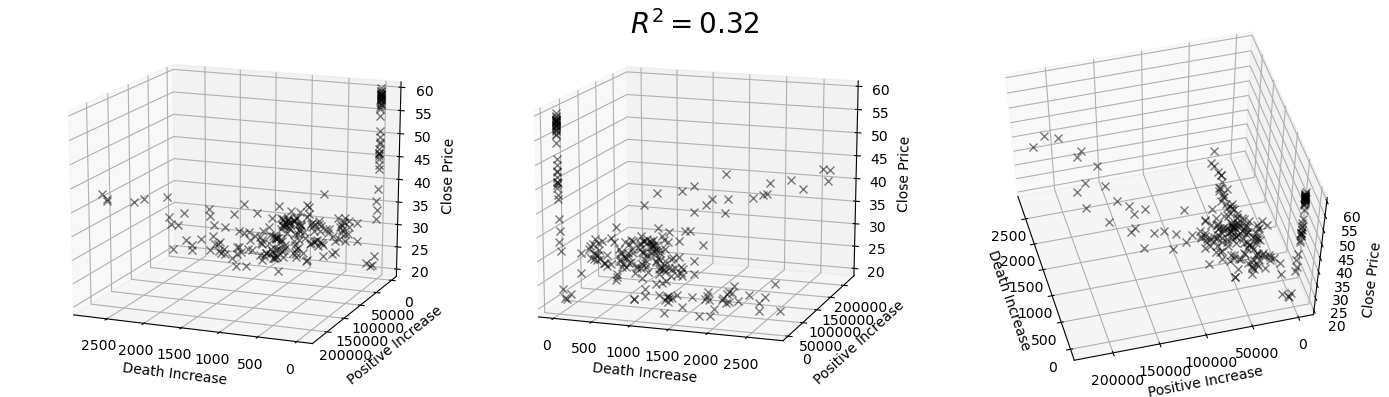

In [384]:
X = dal_reg[['deathIncrease', 'positiveIncrease']].values.reshape(-1,2)
Y = dal_reg['Close']

x = X[:, 0]
y = X[:, 1]
z = Y

ols = linear_model.LinearRegression()
model = ols.fit(X, Y)

r2 = model.score(X, Y)

plt.style.use('default')

fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='black', zorder=14, linestyle='none', marker='x', alpha=0.5)
    ax.set_xlabel('Death Increase', fontsize=10)
    ax.set_ylabel('Positive Increase', fontsize=10)
    ax.set_zlabel('Close Price', fontsize=10)

ax1.view_init(elev=17, azim=112)
ax2.view_init(elev=16, azim=-71)
ax3.view_init(elev=55, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

In [385]:
model.coef_

array([-9.89521743e-03,  5.09387964e-05])

#### Interestingly, the coefficients for Delta Airlines were quite low while the r-squared value was the highest out of all three regressions. We found this surprising because we would have imagined that the increase in positive test cases to be correlated to the demand for flights. However, it also makes sense that other factors like lockdowns and international travel regulations would have a bigger impact. Overall, it seems that COVID-19 factors itself have little to do with the stock of specific companies but rather the policies induced by COVID-19 that are impacting businesses the most. 

# Conclusion:

The COVID-19 pandemic's effect on the stock market is a hotly debated topic. From our analysis, we conclude that COVID-19 death rates have little impact on the stock market - what seems to be more important is public sentiment/interest (as seen by our Google trends data), and outside factors such as policies and innovations. We found that Google searches for "COVID-19 Vaccine" have a strong predictive power across all indices, as did searches "COVID-19", although P-values were higher for "COVID-19" than for "COVID-19 Vaccine", which had all 5 P-values under 0.05. We eliminated many possibilities for confounding factors by showing that these correlations do not apply to similar control groups.